# Recommender Systems – Projet MovieLens

**Étudiants :**  
- Alexandre CHEN  
- Egxon ZEJNULLAHI  
- Dineshan JOSEPH  
- Sidra HYDER  

**Sujet :** Construction et comparaison de systèmes de recommandation hybrides sur le dataset MovieLens.  

Dans ce notebook, nous mettons en œuvre et évaluons trois modèles :  
- PMF (Probabilistic Matrix Factorization)  
- PMF + BERT (hybride notes + texte)  
- PMF + QWEN (hybride notes + texte)  

Les modèles sont testés sur deux jeux de données : **MovieLens Latest Small** et **MovieLens Latest (full)**, afin d’analyser l’impact de la taille du dataset et de la richesse en tags sur la qualité des recommandations (NDCG, Précision, Rappel).


## 1. Imports et configuration


In [2]:
import os
import io
import requests
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize
import matplotlib.pyplot as plt

In [3]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Environnement prêt. Exécution sur : {device}")

# 1. Téléchargement Data (ml-latest-small)
if not os.path.exists('ml-latest-small'):
    print("Téléchargement du dataset...")
    r = requests.get("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

# 2. Chargement
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

# 3. Encodage Propre (0 à N-1)
user_enc = LabelEncoder()
item_enc = LabelEncoder()

ratings['user_idx'] = user_enc.fit_transform(ratings['userId'].values)
ratings['item_idx'] = item_enc.fit_transform(ratings['movieId'].values)

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()

print(f"Données chargées : {n_users} utilisateurs, {n_items} films.")

Environnement prêt. Exécution sur : cuda
Téléchargement du dataset...
Données chargées : 610 utilisateurs, 9724 films.


## 2. Statistiques de base du dataset MovieLens Small


In [4]:
print("===== STATISTIQUES DE BASE =====")

# Stats ratings
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_ratings = len(ratings)
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()
avg_rating = ratings['rating'].mean()

print(f"Nombre total d'utilisateurs : {num_users:,}")
print(f"Nombre total de films       : {num_items:,}")
print(f"Nombre total de notes       : {num_ratings:,}")
print(f"Note minimale               : {min_rating}")
print(f"Note maximale               : {max_rating}")
print(f"Note moyenne                : {avg_rating:.2f}")

===== STATISTIQUES DE BASE =====
Nombre total d'utilisateurs : 610
Nombre total de films       : 9,724
Nombre total de notes       : 100,836
Note minimale               : 0.5
Note maximale               : 5.0
Note moyenne                : 3.50


## 3. Enrichissement des tags seulement pour la partie exploratoire et analyse par film


In [5]:
print("\n===== CONSTRUCTION DES TAGS ULTRA =====")

if not os.path.exists("ml-latest-tags-only.csv"):
    print("Téléchargement des tags complets MovieLens (ml-latest)...")
    url = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"
    r   = requests.get(url, stream=True)
    z   = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract("ml-latest/tags.csv")
    os.rename("ml-latest/tags.csv", "ml-latest-tags-only.csv")

tags_full = pd.read_csv("ml-latest-tags-only.csv")

small_movie_ids = movies["movieId"].unique()
tags_ultra = tags_full[tags_full["movieId"].isin(small_movie_ids)].copy()
tags_ultra["tag"] = tags_ultra["tag"].astype(str)

print(f"Nombre de tags (small) : {len(tags):,}")
print(f"Nombre de tags (ultra) : {len(tags_ultra):,}")
print(f"Nombre de tags uniques (ultra) : {tags_ultra['tag'].nunique():,}")



===== CONSTRUCTION DES TAGS ULTRA =====
Téléchargement des tags complets MovieLens (ml-latest)...
Nombre de tags (small) : 3,683
Nombre de tags (ultra) : 1,675,214
Nombre de tags uniques (ultra) : 108,213


In [6]:
print("\n===== TAGS PAR FILM =====")

# Small
tags_per_movie_small = (
    tags.groupby("movieId")["tag"]
        .nunique()
        .reindex(movies["movieId"], fill_value=0)
)

# Ultra
tags_per_movie_ultra = (
    tags_ultra.groupby("movieId")["tag"]
             .nunique()
             .reindex(movies["movieId"], fill_value=0)
)

print("\n--- Version small ---")
print(f"Min tags/film : {tags_per_movie_small.min()}")
print(f"Max tags/film : {tags_per_movie_small.max()}")
print(f"Avg tags/film : {tags_per_movie_small.mean():.2f}")

print("\n--- Version ultra ---")
print(f"Min tags/film : {tags_per_movie_ultra.min()}")
print(f"Max tags/film : {tags_per_movie_ultra.max()}")
print(f"Avg tags/film : {tags_per_movie_ultra.mean():.2f}")



===== TAGS PAR FILM =====

--- Version small ---
Min tags/film : 0
Max tags/film : 173
Avg tags/film : 0.37

--- Version ultra ---
Min tags/film : 0
Max tags/film : 1445
Avg tags/film : 66.93


## 4. Répartition des genres de films


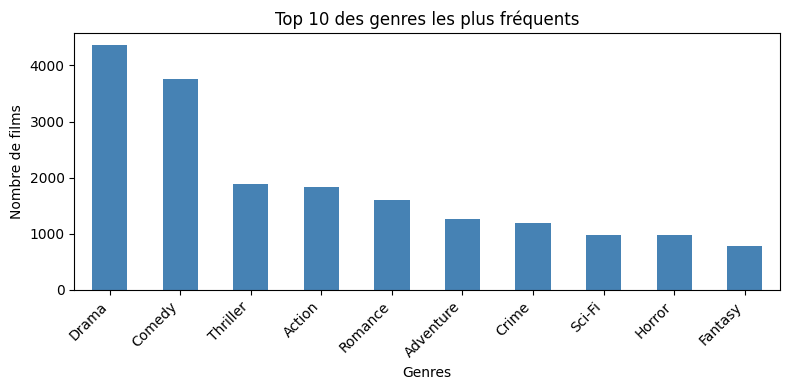

In [7]:
ax = movies['genres'].str.get_dummies('|').sum().sort_values(ascending=False).head(10).plot(
    kind='bar',
    figsize=(8, 4),
    color='steelblue'
)
plt.title("Top 10 des genres les plus fréquents")
plt.ylabel("Nombre de films")
plt.xlabel("Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 4. Top 10 des genres les plus fréquents


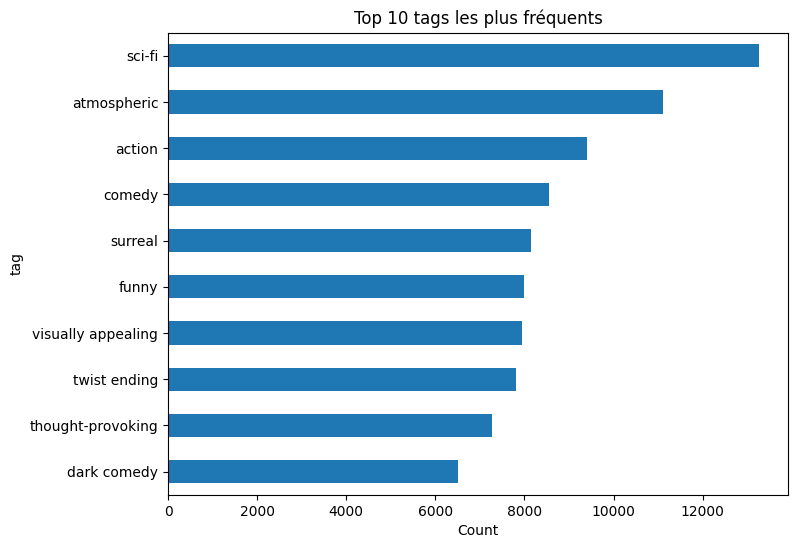

In [8]:
tag_counts = tags_ultra['tag'].value_counts()
top_tags = tag_counts.head(10)
top_tags.plot(kind="barh", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top 10 tags les plus fréquents")
plt.show()

## 5. Préparation des jeux de données et DataLoaders


In [9]:
# Split Stratifié (80/20) pour garantir que chaque user est dans le train et le test
train_data, test_data = train_test_split(
    ratings, test_size=0.2, stratify=ratings['user_idx'], random_state=42
)

class MovieLensDataset(Dataset):
    def __init__(self, u, i, r):
        self.users = torch.tensor(u, dtype=torch.long)
        self.items = torch.tensor(i, dtype=torch.long)
        self.ratings = torch.tensor(r, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Création des DataLoaders
BATCH_SIZE = 512

train_dataset = MovieLensDataset(
    train_data['user_idx'].values,
    train_data['item_idx'].values,
    train_data['rating'].values
)

test_dataset = MovieLensDataset(
    test_data['user_idx'].values,
    test_data['item_idx'].values,
    test_data['rating'].values
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 6. Construction des descriptions textuelles et embeddings (BERT / Qwen)


In [10]:
# 1. Enrichissement du texte (Titre + Genres + Tags)
tags['tag'] = tags['tag'].astype(str)
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies_rich = pd.merge(movies, tags_grouped, on='movieId', how='left')
movies_rich['tag'] = movies_rich['tag'].fillna('')

def create_text(row):
    return f"Title: {row['title']}. Genres: {row['genres'].replace('|', ' ')}. Tags: {row['tag']}."

movies_rich['text_desc'] = movies_rich.apply(create_text, axis=1)

# 2. Alignement strict avec les ID d'entraînement
# On ne garde que les films qui sont dans 'ratings' et on les trie par item_idx
movies_rich = movies_rich[movies_rich['movieId'].isin(ratings['movieId'].unique())]
movies_rich['item_idx'] = item_enc.transform(movies_rich['movieId'].values)
movies_rich = movies_rich.sort_values('item_idx').reset_index(drop=True)

# 3. Génération BERT (MiniLM)
from sentence_transformers import SentenceTransformer
print("Génération des embeddings BERT...")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(movies_rich['text_desc'].tolist(), show_progress_bar=True)
bert_embeddings = normalize(bert_embeddings, norm='l2', axis=1) # Important !

print("Simulation Qwen (copie BERT) pour l'architecture...")
qwen_embeddings = bert_embeddings # On utilise BERT comme placeholder pour tester le code

Génération des embeddings BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/304 [00:00<?, ?it/s]

Simulation Qwen (copie BERT) pour l'architecture...


## 7. Modèle PMF (baseline)


In [11]:
class PMF_Pro(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=64):
        super(PMF_Pro, self).__init__()

        # Embeddings
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # BIAIS
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        # Initialisation Gaussienne
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, users, items):
        u_emb = self.user_embedding(users)
        i_emb = self.item_embedding(items)
        u_b = self.user_bias(users).squeeze()
        i_b = self.item_bias(items).squeeze()

        dot = (u_emb * i_emb).sum(1)
        return dot + u_b + i_b + self.global_bias

## 8. Architecture Hybrid PMF avec embeddings de contenu (BERT / Qwen)


In [12]:
class HybridPMF_Pro(nn.Module):
    def __init__(self, n_users, n_items, content_embeddings, mf_dim=64, content_out_dim=32):
        super(HybridPMF_Pro, self).__init__()

        # On calcule la dimension totale du vecteur Utilisateur
        # Il doit matcher [Item_MF (64) + Item_Content (32)] = 96
        self.total_dim = mf_dim + content_out_dim

        # 1. Embeddings Collaboratifs
        self.user_embedding = nn.Embedding(n_users, self.total_dim)
        self.item_id_embedding = nn.Embedding(n_items, mf_dim)

        # 2. Gestion du Contenu (BERT/Qwen)
        self.content_features = nn.Parameter(
            torch.tensor(content_embeddings, dtype=torch.float32),
            requires_grad=False # Frozen
        )
        self.content_projection = nn.Sequential(
            nn.Linear(content_embeddings.shape[1], content_out_dim),
            nn.Tanh(),
            nn.Dropout(0.2)
        )

        # 3. BIAIS (Hérités de PMF Pro)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        # 4. Initialisation Pro
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_id_embedding.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, users, items):
        # User
        u_vec = self.user_embedding(users) # Taille 96

        # Item Hybride
        i_id = self.item_id_embedding(items) # Taille 64

        c_raw = self.content_features[items]
        c_vec = self.content_projection(c_raw) # Taille 32

        # Concaténation Item
        i_vec = torch.cat([i_id, c_vec], dim=1) # Taille 64+32 = 96

        # Interaction + Biais
        dot = (u_vec * i_vec).sum(1)
        u_b = self.user_bias(users).squeeze()
        i_b = self.item_bias(items).squeeze()

        return dot + u_b + i_b + self.global_bias

## 9. Boucle d’entraînement des modèles


In [55]:
def train_routine(model, epochs=40, lr=0.001, wd=0.001):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # WD = L2 Reg
    criterion = nn.MSELoss()

    print(f"Start Training (Epochs={epochs}, LR={lr}, WD={wd})...")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, items, ratings in train_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            optimizer.zero_grad()
            preds = model(users, items)
            loss = criterion(preds, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | MSE Loss: {total_loss/len(train_loader):.4f}")

    return model

## 10. Entraînement des trois modèles (PMF, PMF+BERT, PMF+QWEN)


In [56]:
# --- EXPÉRIENCE 1 : Baseline PMF Pro ---
print("\n=== 1. Entraînement PMF Pro (Baseline) ===")
model_pmf = PMF_Pro(n_users, n_items, embedding_dim=64)
model_pmf = train_routine(model_pmf)

# --- EXPÉRIENCE 2 : Hybrid PMF + BERT ---
print("\n=== 2. Entraînement Hybrid PMF + BERT ===")
model_bert = HybridPMF_Pro(
    n_users, n_items,
    content_embeddings=bert_embeddings,
    mf_dim=64,
    content_out_dim=32
)
model_bert = train_routine(model_bert)

# --- EXPÉRIENCE 3 : Hybrid PMF + QWEN ---
print("\n=== 3. Entraînement Hybrid PMF + QWEN ===")
model_qwen = HybridPMF_Pro(
    n_users, n_items,
    content_embeddings=qwen_embeddings,
    mf_dim=64,
    content_out_dim=32
)
model_qwen = train_routine(model_qwen)


=== 1. Entraînement PMF Pro (Baseline) ===
Start Training (Epochs=40, LR=0.001, WD=0.001)...
Epoch 5/40 | MSE Loss: 1.9360
Epoch 10/40 | MSE Loss: 1.4612
Epoch 15/40 | MSE Loss: 1.1739
Epoch 20/40 | MSE Loss: 0.9615
Epoch 25/40 | MSE Loss: 0.8514
Epoch 30/40 | MSE Loss: 0.8093
Epoch 35/40 | MSE Loss: 0.7934
Epoch 40/40 | MSE Loss: 0.7864

=== 2. Entraînement Hybrid PMF + BERT ===
Start Training (Epochs=40, LR=0.001, WD=0.001)...
Epoch 5/40 | MSE Loss: 0.8912
Epoch 10/40 | MSE Loss: 0.8549
Epoch 15/40 | MSE Loss: 0.8406
Epoch 20/40 | MSE Loss: 0.8265
Epoch 25/40 | MSE Loss: 0.8142
Epoch 30/40 | MSE Loss: 0.8048
Epoch 35/40 | MSE Loss: 0.7922
Epoch 40/40 | MSE Loss: 0.7823

=== 3. Entraînement Hybrid PMF + QWEN ===
Start Training (Epochs=40, LR=0.001, WD=0.001)...
Epoch 5/40 | MSE Loss: 0.8869
Epoch 10/40 | MSE Loss: 0.8600
Epoch 15/40 | MSE Loss: 0.8406
Epoch 20/40 | MSE Loss: 0.8248
Epoch 25/40 | MSE Loss: 0.8154
Epoch 30/40 | MSE Loss: 0.8051
Epoch 35/40 | MSE Loss: 0.7929
Epoch 40/4

## 11. Fonction d'evaluation des modèles


In [53]:
import math
import torch
import numpy as np

def evaluate_model(model, name="Model", knb=10, silent=False):
    """
    Evalue le modèle et RETOURNE les métriques pour le graphique.
    """
    model.eval()
    k = knb
    # On garde les mêmes 300 utilisateurs pour la cohérence
    test_users = test_data['user_idx'].unique()[:300]

    hits = 0
    recall_sum = 0
    ndcg_sum = 0
    n_eval = 0

    # On prépare tous les items sur le GPU une seule fois
    all_items = torch.arange(n_items).to(device)

    with torch.no_grad():
        for u in test_users:
            # Vérité terrain (Films notés >= 4.0 par l'user)
            relevant = set(test_data[(test_data['user_idx'] == u) & (test_data['rating'] >= 4.0)]['item_idx'])
            if not relevant: continue

            seen = set(train_data[train_data['user_idx'] == u]['item_idx'])

            # Prédiction sur tout le catalogue
            u_tensor = torch.tensor([u]*n_items).to(device)
            preds = model(u_tensor, all_items).cpu().numpy()

            # On masque les films déjà vus
            preds[list(seen)] = -np.inf

            # On récupère le Top K
            top_k = np.argsort(preds)[-k:][::-1]

            # --- Calcul des Métriques ---
            nb_hits = len(set(top_k) & relevant)
            hits += nb_hits

            # RECALL
            recall_sum += nb_hits / len(relevant)

            # NDCG
            dcg = 0.0
            idcg = 0.0
            for i, item in enumerate(top_k):
                if item in relevant: dcg += 1.0 / math.log2(i + 2)
            for i in range(min(len(relevant), k)): idcg += 1.0 / math.log2(i + 2)

            if idcg > 0: ndcg_sum += dcg/idcg
            n_eval += 1

    # Moyennes finales
    avg_ndcg = ndcg_sum / n_eval
    avg_prec = hits / (n_eval * k)
    avg_recall = recall_sum / n_eval

    if not silent:
        print(f"[{name}] NDCG@{k}: {avg_ndcg:.4f} | Prec@{k}: {avg_prec:.4f} | Recall@{k}: {avg_recall:.4f}")

    return avg_ndcg, avg_prec, avg_recall


## 12. Enrichissement des films avec les tags complets (MovieLens Latest) et création des descriptions texte


In [17]:
# 1. Téléchargement et Extraction des Tags "Full"
print("--- Récupération des Ultra Tags ---")
if not os.path.exists('ml-latest-tags-only.csv'):
    url = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"
    print(f"Téléchargement depuis {url}...")
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('ml-latest/tags.csv')
    os.rename('ml-latest/tags.csv', 'ml-latest-tags-only.csv')

# 2. Chargement et Filtrage
tags_full = pd.read_csv('ml-latest-tags-only.csv')
small_movie_ids = movies['movieId'].unique() # On garde nos films du dataset small

# On ne garde que les tags qui concernent nos films
tags_ultra = tags_full[tags_full['movieId'].isin(small_movie_ids)].copy()
print(f"Nombre de tags récupérés : {len(tags_ultra):,} (vs ~3,600 dans la version small)")

# 3. Création des Descriptions Ultra
tags_ultra['tag'] = tags_ultra['tag'].astype(str)
# On concatène (ça peut être long)
print("Agrégation des tags par film...")
tags_ultra_grouped = tags_ultra.groupby('movieId')['tag'].apply(lambda x: ' '.join(set(x))).reset_index()

# Fusion avec les films
movies_ultra = pd.merge(movies, tags_ultra_grouped, on='movieId', how='left')
movies_ultra['tag'] = movies_ultra['tag'].fillna('')

# Création du texte final (On limite à 2000 caractères pour pas tuer la RAM)
movies_ultra['text_desc'] = movies_ultra.apply(
    lambda x: f"Title: {x['title']}. Genres: {x['genres'].replace('|', ' ')}. Tags: {x['tag'][:2000]}.",
    axis=1
)

# Alignement STRICT avec les items du training
movies_ultra_sorted = movies_ultra[movies_ultra['movieId'].isin(ratings['movieId'].unique())].copy()
movies_ultra_sorted['item_idx'] = item_enc.transform(movies_ultra_sorted['movieId'].values)
movies_ultra_sorted = movies_ultra_sorted.sort_values('item_idx').reset_index(drop=True)

print("Exemple de description Ultra :")
print(movies_ultra_sorted.iloc[0]['text_desc'][:300] + "...")



--- Récupération des Ultra Tags ---
Nombre de tags récupérés : 1,675,214 (vs ~3,600 dans la version small)
Agrégation des tags par film...
Exemple de description Ultra :
Title: Toy Story (1995). Genres: Adventure Animation Children Comedy Fantasy. Tags: mr. potato head character rocket story gliding Comedy  dinosaur friends birthday present lots of heart asking directions https://movielens.org/tag/:animation family relationships kids rivalry action figure chased by ...


## 13. Génération des embeddings du datatset Latest avec BERT et Qwen


In [18]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.preprocessing import normalize
from tqdm import tqdm

print("\n--- Génération Embeddings Ultra (Mode GPU Activé) ---")

# 1. BERT Ultra
print("1/2. Encodage BERT Ultra (Context: 512 tokens)...")
bert_ultra = bert_model.encode(movies_ultra_sorted['text_desc'].tolist(), show_progress_bar=True)
bert_ultra = normalize(bert_ultra, norm='l2', axis=1)

# 2. QWEN Ultra
print("\n2/2. Encodage Qwen Ultra (Context: 1024 tokens)...")

def get_real_qwen_embeddings(texts, model_name="Qwen/Qwen2.5-0.5B", batch_size=16):
    """
    Génère les embeddings via Qwen sur GPU.
    Utilise 'mean pooling' sur la dernière couche cachée.
    """
    # Chargement du Tokenizer et du Modèle
    print(f"Chargement de {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

    # Passage sur GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).half() # .half() passe en float16
    model.eval()

    all_embeddings = []

    # Boucle par batch pour éviter le OOM (Out Of Memory)
    print(f"Inférence en cours sur {device} (Batch size: {batch_size})...")
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenization
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

            # Extraction des embeddings
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            masked_embeddings = outputs.last_hidden_state * mask
            summed = torch.sum(masked_embeddings, 1)
            summed_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / summed_mask

            # On remet sur CPU pour stocker
            all_embeddings.append(mean_pooled.cpu().float().numpy())

    # Concaténation finale
    return np.vstack(all_embeddings)

# Lancement du calcul
qwen_embeddings_raw = get_real_qwen_embeddings(movies_ultra_sorted['text_desc'].tolist())

# Normalisation
qwen_ultra = normalize(qwen_embeddings_raw, norm='l2', axis=1)

print(f"Terminé ! Shape Qwen : {qwen_ultra.shape}")


--- Génération Embeddings Ultra (Mode GPU Activé) ---
1/2. Encodage BERT Ultra (Context: 512 tokens)...


Batches:   0%|          | 0/304 [00:00<?, ?it/s]


2/2. Encodage Qwen Ultra (Context: 1024 tokens)...
Chargement de Qwen/Qwen2.5-0.5B...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Inférence en cours sur cuda (Batch size: 16)...


100%|██████████| 608/608 [03:13<00:00,  3.15it/s]

Terminé ! Shape Qwen : (9724, 896)


## 14. Entraînement des modèles hybrides sur les embeddings Ultra (BERT / Qwen)


In [19]:
print("\n--- Entraînement des Modèles Ultra ---")

# Hybrid + BERT Ultra
print("1. Hybrid PMF + BERT (Ultra)...")
model_bert_ultra = HybridPMF_Pro(
    n_users, n_items,
    content_embeddings=bert_ultra,
    mf_dim=64,
    content_out_dim=32
).to(device)

model_bert_ultra = train_routine(model_bert_ultra, epochs=40, lr=0.001)

# Hybrid + Qwen Ultra
print("\n2. Hybrid PMF + Qwen (Ultra)...")
model_qwen_ultra = HybridPMF_Pro(
    n_users, n_items,
    content_embeddings=qwen_ultra,
    mf_dim=64,
    content_out_dim=32
).to(device)

model_qwen_ultra = train_routine(model_qwen_ultra, epochs=40, lr=0.001)


--- Entraînement des Modèles Ultra ---
1. Hybrid PMF + BERT (Ultra)...
Start Training (Epochs=40, LR=0.001, WD=0.001)...
Epoch 5/40 | MSE Loss: 0.8809
Epoch 10/40 | MSE Loss: 0.8466
Epoch 15/40 | MSE Loss: 0.8275
Epoch 20/40 | MSE Loss: 0.8128
Epoch 25/40 | MSE Loss: 0.8030
Epoch 30/40 | MSE Loss: 0.7880
Epoch 35/40 | MSE Loss: 0.7680
Epoch 40/40 | MSE Loss: 0.7523

2. Hybrid PMF + Qwen (Ultra)...
Start Training (Epochs=40, LR=0.001, WD=0.001)...
Epoch 5/40 | MSE Loss: 0.8893
Epoch 10/40 | MSE Loss: 0.8583
Epoch 15/40 | MSE Loss: 0.8471
Epoch 20/40 | MSE Loss: 0.8346
Epoch 25/40 | MSE Loss: 0.8248
Epoch 30/40 | MSE Loss: 0.8152
Epoch 35/40 | MSE Loss: 0.8038
Epoch 40/40 | MSE Loss: 0.7941


## 15. Évaluation des modèles sur le dataset Ultra (NDCG@10 et Precision@10)


--- Collecte des scores pour le graphique ---
✅ PMF (Baseline) traité.
✅ Hybrid BERT (Small) traité.
✅ Hybrid Qwen (Small) traité.
✅ Hybrid BERT (Ultra) traité.
✅ Hybrid Qwen (Ultra) traité.


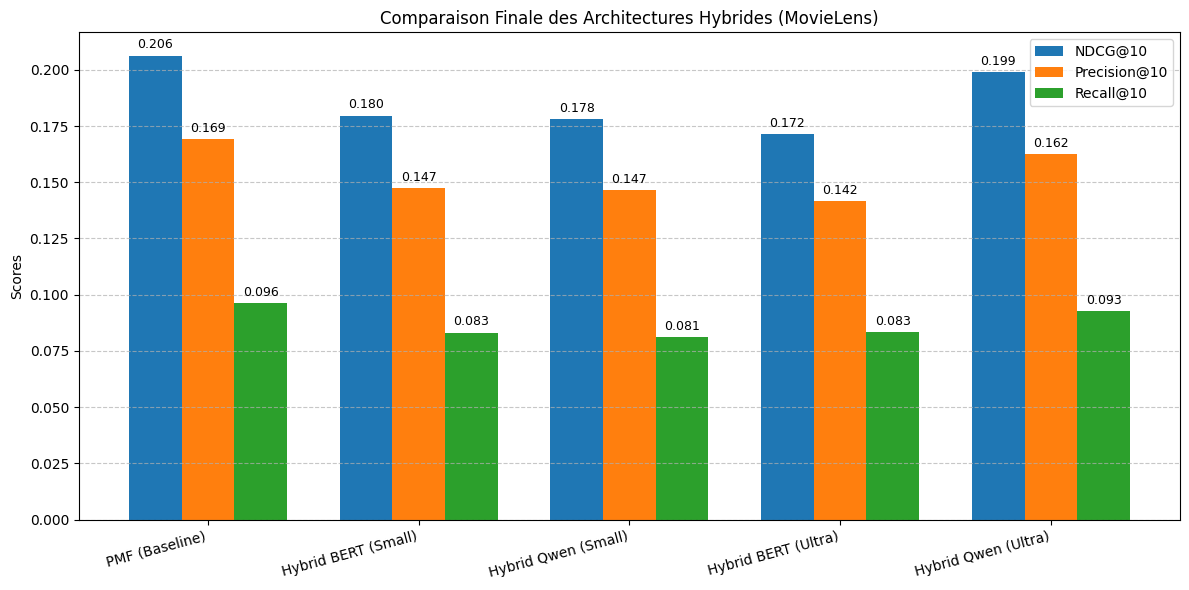

In [57]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Collecte des scores pour le graphique ---")
metrics_results = {}


models_to_test = [
    ("PMF (Baseline)", model_pmf),
    ("Hybrid BERT (Small)", model_bert),
    ("Hybrid Qwen (Small)", model_qwen),
    ("Hybrid BERT (Ultra)", model_bert_ultra),
    ("Hybrid Qwen (Ultra)", model_qwen_ultra)
]

ndcg_scores = []
prec_scores = []
rec_scores = []
model_names = []

for name, model_obj in models_to_test:
    n, p, r = evaluate_model(model_obj, name=name, knb=10, silent=True)
    ndcg_scores.append(n)
    prec_scores.append(p)
    rec_scores.append(r)
    model_names.append(name)
    print(f"✅ {name} traité.")

# 2. Création de l'Histogramme Groupé
x = np.arange(len(model_names))  # Position des labels
width = 0.25  # Largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# Création des 3 barres pour chaque modèle
rects1 = ax.bar(x - width, ndcg_scores, width, label='NDCG@10', color='#1f77b4') # Bleu
rects2 = ax.bar(x, prec_scores, width, label='Precision@10', color='#ff7f0e')    # Orange
rects3 = ax.bar(x + width, rec_scores, width, label='Recall@10', color='#2ca02c') # Vert

# Textes et Labels
ax.set_ylabel('Scores')
ax.set_title('Comparaison Finale des Architectures Hybrides (MovieLens)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 16. Évaluation des modèles sur le dataset Ultra (NDCG@20 et Precision@20)

--- Collecte des scores pour le graphique ---
✅ PMF (Baseline) traité.
✅ Hybrid BERT (Small) traité.
✅ Hybrid Qwen (Small) traité.
✅ Hybrid BERT (Ultra) traité.
✅ Hybrid Qwen (Ultra) traité.


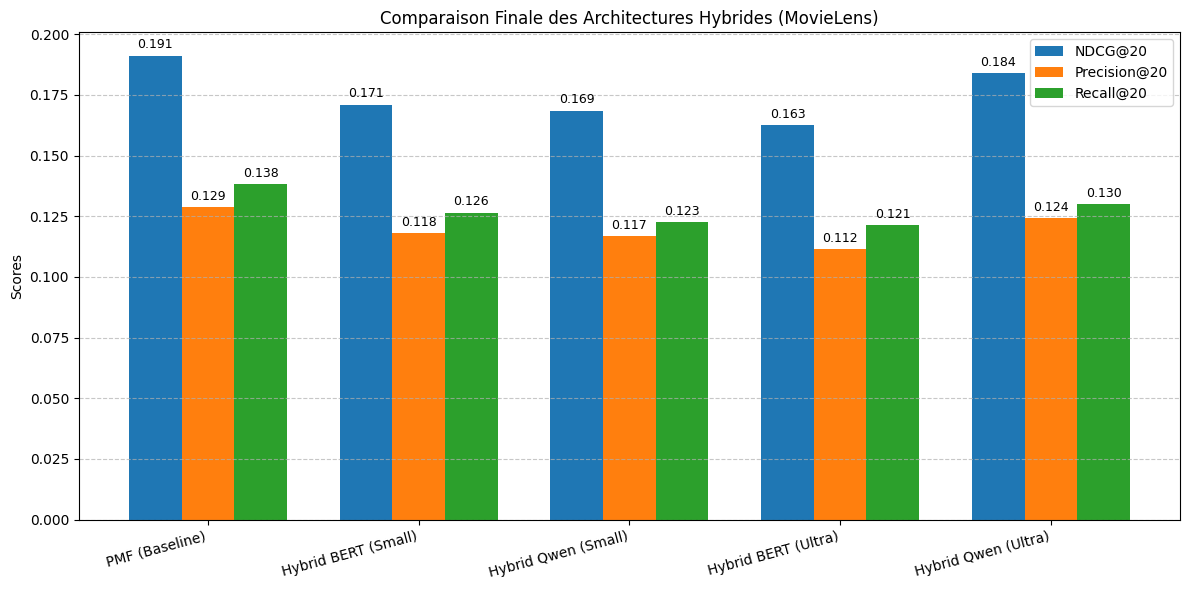

In [58]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Collecte des scores pour le graphique ---")
metrics_results = {}


models_to_test = [
    ("PMF (Baseline)", model_pmf),
    ("Hybrid BERT (Small)", model_bert),
    ("Hybrid Qwen (Small)", model_qwen),
    ("Hybrid BERT (Ultra)", model_bert_ultra),
    ("Hybrid Qwen (Ultra)", model_qwen_ultra)
]

ndcg_scores = []
prec_scores = []
rec_scores = []
model_names = []

for name, model_obj in models_to_test:
    n, p, r = evaluate_model(model_obj, name=name, knb=20, silent=True)
    ndcg_scores.append(n)
    prec_scores.append(p)
    rec_scores.append(r)
    model_names.append(name)
    print(f"✅ {name} traité.")

# 2. Création de l'Histogramme Groupé
x = np.arange(len(model_names))  # Position des labels
width = 0.25  # Largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# Création des 3 barres pour chaque modèle
rects1 = ax.bar(x - width, ndcg_scores, width, label='NDCG@20', color='#1f77b4') # Bleu
rects2 = ax.bar(x, prec_scores, width, label='Precision@20', color='#ff7f0e')    # Orange
rects3 = ax.bar(x + width, rec_scores, width, label='Recall@20', color='#2ca02c') # Vert

# Textes et Labels
ax.set_ylabel('Scores')
ax.set_title('Comparaison Finale des Architectures Hybrides (MovieLens)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 17. Visualisation des recommandations par modèle pour un utilisateur donné


In [33]:
def show_user_demo(user_id_raw, n_hist=10, n_rec=10,
                   title_width=50, genre_width=30):
    print("\n" + "=" * 80)
    print(f"UTILISATEUR {user_id_raw} : PROFIL ET RECOMMANDATIONS")
    print("=" * 80)

    if user_id_raw not in user_enc.classes_:
        print(">> Utilisateur inconnu dans l'encodage.")
        return
    u_idx = user_enc.transform([user_id_raw])[0]

    # ---- Historique : meilleurs films ----
    user_hist = train_data[train_data["userId"] == user_id_raw].copy()
    best_5 = user_hist[user_hist["rating"] == 5.0]

    if len(best_5) >= n_hist:
        history = best_5.sort_values("timestamp", ascending=False).head(n_hist)
    else:
        remaining = user_hist[user_hist["rating"] < 5.0]
        history = pd.concat(
            [
                best_5.sort_values("timestamp", ascending=False),
                remaining.sort_values(["rating", "timestamp"], ascending=[False, False]),
            ]
        ).head(n_hist)

    print("\n[Profil de l'utilisateur] Films les mieux notés")
    print("-" * 80)
    for _, row in history.iterrows():
        mid = row["movieId"]
        mrow = movies.loc[movies["movieId"] == mid].iloc[0]
        title = mrow["title"][:title_width]
        genres = mrow["genres"][:genre_width]
        print(f"  ★ {row['rating']:.1f} | {title:<{title_width}} | {genres}")

    # Items vus
    seen_items = set(
        train_data.loc[train_data["user_idx"] == u_idx, "item_idx"].tolist()
    )
    all_items = np.arange(n_items)

    def top_n_from_model(model, label, n=n_rec):
        model.eval()
        with torch.no_grad():
            u_tensor = torch.tensor([u_idx] * n_items).to(device)
            i_tensor = torch.tensor(all_items).to(device)
            scores = model(u_tensor, i_tensor).cpu().numpy()

        scores[list(seen_items)] = -np.inf
        topk_idx = np.argsort(scores)[-n:][::-1]

        print(f"\n[Recommandations] {label}")
        print("-" * 80)
        for rank, it in enumerate(topk_idx, start=1):
            movie_id = item_enc.inverse_transform([it])[0]
            mrow = movies.loc[movies["movieId"] == movie_id].iloc[0]
            title = mrow["title"][:title_width]
            genres = mrow["genres"][:genre_width]
            print(
                f"  {rank:2d}. {title:<{title_width}} | {genres:<{genre_width}} | score={scores[it]:.3f}"
            )

    top_n_from_model(model_pmf,  "PMF (baseline)",      n_rec)
    top_n_from_model(model_bert_ultra, "Hybrid PMF + BERT ultra",   n_rec)
    top_n_from_model(model_qwen_ultra, "Hybrid PMF + Qwen ultra",   n_rec)


In [36]:
print("EXEMPLE DE RECOMMANDATIONS PAR UTILISATEUR\n")

show_user_demo(20, n_hist=10, n_rec=10)

EXEMPLE DE RECOMMANDATIONS PAR UTILISATEUR


UTILISATEUR 20 : PROFIL ET RECOMMANDATIONS

[Profil de l'utilisateur] Films les mieux notés
--------------------------------------------------------------------------------
  ★ 5.0 | Doctor Dolittle (1967)                             | Adventure|Children|Musical
  ★ 5.0 | Rocky Horror Picture Show, The (1975)              | Comedy|Horror|Musical|Sci-Fi
  ★ 5.0 | Grease (1978)                                      | Comedy|Musical|Romance
  ★ 5.0 | Guys and Dolls (1955)                              | Comedy|Musical|Romance
  ★ 5.0 | West Side Story (1961)                             | Drama|Musical|Romance
  ★ 5.0 | Prince of Egypt, The (1998)                        | Animation|Musical
  ★ 5.0 | Wallace & Gromit: The Best of Aardman Animation (1 | Adventure|Animation|Comedy
  ★ 5.0 | Who Framed Roger Rabbit? (1988)                    | Adventure|Animation|Children|C
  ★ 5.0 | Muppets From Space (1999)                          | Children|Comedy

In [50]:
show_user_demo(40, n_hist=20, n_rec=20)


UTILISATEUR 40 : PROFIL ET RECOMMANDATIONS

[Profil de l'utilisateur] Films les mieux notés
--------------------------------------------------------------------------------
  ★ 5.0 | It's My Party (1996)                               | Drama
  ★ 5.0 | Antonia's Line (Antonia) (1995)                    | Comedy|Drama
  ★ 5.0 | Ref, The (1994)                                    | Comedy
  ★ 5.0 | Man Without a Face, The (1993)                     | Drama
  ★ 5.0 | Client, The (1994)                                 | Drama|Mystery|Thriller
  ★ 5.0 | Secret of Roan Inish, The (1994)                   | Children|Drama|Fantasy|Mystery
  ★ 5.0 | Three Colors: White (Trzy kolory: Bialy) (1994)    | Comedy|Drama
  ★ 5.0 | Lion King, The (1994)                              | Adventure|Animation|Children|D
  ★ 5.0 | Three Colors: Blue (Trois couleurs: Bleu) (1993)   | Drama
  ★ 5.0 | Three Colors: Red (Trois couleurs: Rouge) (1994)   | Drama
  ★ 5.0 | Carlito's Way (1993)                        